In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

Use python urllib library to extract the KDD Cup 99 data from their web repository

In [0]:
import urllib.request
urllib.request.urlretrieve("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz", "/tmp/kddcup_data.gz")
dbutils.fs.mv("file:/tmp/kddcup_data.gz", "dbfs:/kdd/kddcup_data.gz")
display(dbutils.fs.ls("dbfs:/kdd"))

path,name,size,modificationTime
dbfs:/kdd/kddcup_data.gz,kddcup_data.gz,2144903,1667174513000


Load the data and print 10

In [0]:
data_file = "dbfs:/kdd"

df = spark.read \
  .format("csv") \
  .option("inferSchema", True) \
  .option("header", False) \
  .option("sep", ',') \
  .option("path", data_file) \
  .load()

In [0]:
df.show(10)

+---+---+----+---+---+----+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------+
|_c0|_c1| _c2|_c3|_c4| _c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|   _c41|
+---+---+----+---+---+----+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------+
|  0|tcp|http| SF|181|5450|  0|  0|  0|  0|   0|   1|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   8|   8| 0.0| 0.0| 0.0| 0.0| 1.0| 0.0| 0.0|   9|   9| 1.0| 0.0|0.11| 0.0| 0.0| 0.0| 0.0| 0.0|normal.|
|  0|tcp|http| SF|239| 486|  0|  0|  0|  0|   0|   1|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   8|   8| 0.0| 0.0| 0.0| 0.0| 1.0| 0.0| 0.0|  19|  19| 1.0| 0.0|0.05

verify the type of data structure of your data

In [0]:
df.schema

Out[5]: StructType(List(StructField(_c0,IntegerType,true),StructField(_c1,StringType,true),StructField(_c2,StringType,true),StructField(_c3,StringType,true),StructField(_c4,IntegerType,true),StructField(_c5,IntegerType,true),StructField(_c6,IntegerType,true),StructField(_c7,IntegerType,true),StructField(_c8,IntegerType,true),StructField(_c9,IntegerType,true),StructField(_c10,IntegerType,true),StructField(_c11,IntegerType,true),StructField(_c12,IntegerType,true),StructField(_c13,IntegerType,true),StructField(_c14,IntegerType,true),StructField(_c15,IntegerType,true),StructField(_c16,IntegerType,true),StructField(_c17,IntegerType,true),StructField(_c18,IntegerType,true),StructField(_c19,IntegerType,true),StructField(_c20,IntegerType,true),StructField(_c21,IntegerType,true),StructField(_c22,IntegerType,true),StructField(_c23,IntegerType,true),StructField(_c24,DoubleType,true),StructField(_c25,DoubleType,true),StructField(_c26,DoubleType,true),StructField(_c27,DoubleType,true),StructField(_

extract these 6 columns (duration, protocol_type, service, src_bytes, dst_bytes, flag and label) from your dataset

In [0]:
dff = df.select(col("_c0"),col("_c1"),col("_c2"),col("_c4"),col("_c5"),col("_c6"),col("_c41"))

Print schema and display 10 values

In [0]:
dff.show(10)

+---+---+----+---+----+---+-------+
|_c0|_c1| _c2|_c4| _c5|_c6|   _c41|
+---+---+----+---+----+---+-------+
|  0|tcp|http|181|5450|  0|normal.|
|  0|tcp|http|239| 486|  0|normal.|
|  0|tcp|http|235|1337|  0|normal.|
|  0|tcp|http|219|1337|  0|normal.|
|  0|tcp|http|217|2032|  0|normal.|
|  0|tcp|http|217|2032|  0|normal.|
|  0|tcp|http|212|1940|  0|normal.|
|  0|tcp|http|159|4087|  0|normal.|
|  0|tcp|http|210| 151|  0|normal.|
|  0|tcp|http|212| 786|  0|normal.|
+---+---+----+---+----+---+-------+
only showing top 10 rows



In [0]:
dff.schema

Out[8]: StructType(List(StructField(_c0,IntegerType,true),StructField(_c1,StringType,true),StructField(_c2,StringType,true),StructField(_c4,IntegerType,true),StructField(_c5,IntegerType,true),StructField(_c6,IntegerType,true),StructField(_c41,StringType,true)))

total number of connections based on the protocol_type and based on the service

In [0]:
dff.groupBy((col("_c1")).alias("Protocal_Type")).count().sort("count", ascending = True).show()

+-------------+------+
|Protocal_Type| count|
+-------------+------+
|          udp| 20354|
|          tcp|190065|
|         icmp|283602|
+-------------+------+



In [0]:
p = dff.groupBy((col("_c1")).alias("Protocal_Type")).count().sort("count", ascending = True)
p_pandas = p.toPandas()

Out[86]: <AxesSubplot:xlabel='Protocal_Type'>

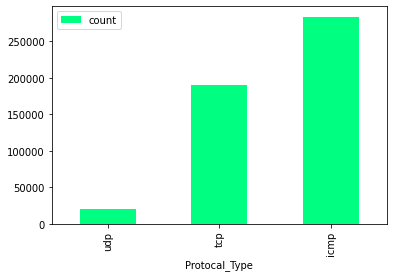

In [0]:
p_pandas.plot(kind='bar', x = "Protocal_Type", y = 'count', colormap='winter_r')

In [0]:
pp = dff.groupBy((col("_c2")).alias("Service")).count().sort("count", ascending = True)
pp_pandas = pp.toPandas()

Out[18]: <AxesSubplot:xlabel='Service'>

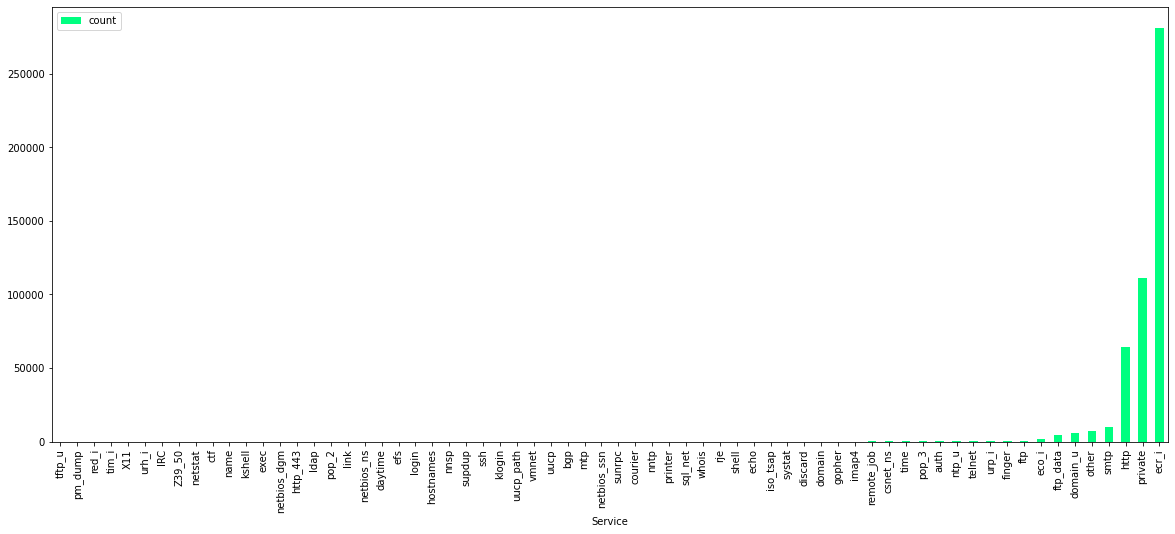

In [0]:
import matplotlib.pyplot as plt
pp_pandas.plot(kind='bar', x = "Service", y = 'count', colormap='winter_r',figsize=(20, 8))

In [0]:
p2 = dff.groupBy((col("_c2")).alias("Service Type")).count().sort("count", ascending = False)
p2.show(10)

+------------+------+
|Service Type| count|
+------------+------+
|       ecr_i|281400|
|     private|110893|
|        http| 64293|
|        smtp|  9723|
|       other|  7237|
|    domain_u|  5863|
|    ftp_data|  4721|
|       eco_i|  1642|
|         ftp|   798|
|      finger|   670|
+------------+------+
only showing top 10 rows



further exploratory data analysis

Out[88]: <AxesSubplot:ylabel='count'>

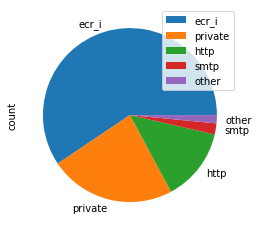

In [0]:
p2_pandas = p2.toPandas()
p2_pandastop = p2_pandas[0:5]
p2_pandastop.plot(kind='pie', y = 'count', labels = p2_pandastop['Service Type'])

In [0]:
p3 = dff.groupBy((col("_c1")).alias("Protocal_Type")).sum('_c4')
p3.show()

+-------------+----------+
|Protocal_Type|  sum(_c4)|
+-------------+----------+
|          tcp|1229530130|
|          udp|   1911953|
|         icmp| 263272941|
+-------------+----------+



Out[90]: Text(0, 0.5, 'total src_types')

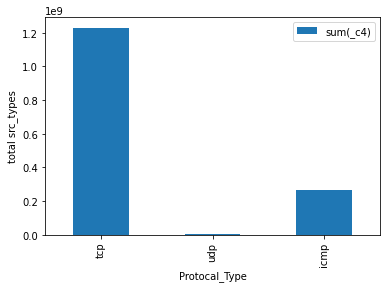

In [0]:
import matplotlib.pyplot as plt
p3_pandas = p3.toPandas()
p3_pandas.plot(kind='bar', y='sum(_c4)',x='Protocal_Type')
plt.ylabel('total src_types')

In [0]:
p4 = dff.groupBy((col("_c2")).alias("Service Type")).sum('_c0').sort("sum(_c0)", ascending = False)
p4.show()

+------------+--------+
|Service Type|sum(_c0)|
+------------+--------+
|       other|20379049|
|     private| 1398901|
|      telnet|  456677|
|         ftp|  337665|
|    ftp_data|  333520|
|         IRC|  315753|
|    domain_u|  124372|
|        http|   81411|
|      supdup|   40686|
|    csnet_ns|   40452|
|       pop_3|   40444|
|     printer|   30935|
|         efs|   30835|
|     courier|   30619|
|        uucp|   30418|
|        smtp|   27626|
|       ntp_u|    1889|
|      finger|     737|
|         X11|     343|
|       login|     201|
+------------+--------+
only showing top 20 rows



Out[92]: Text(0, 0.5, 'duration')

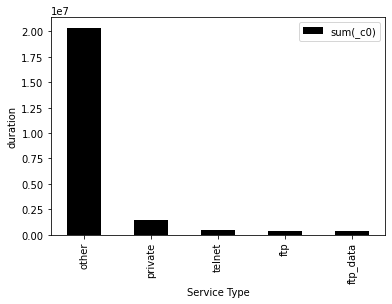

In [0]:
p4_pandas = p4.toPandas()
p4_pandastop = p4_pandas[0:5]
p4_pandastop.plot(kind='bar',y='sum(_c0)',x='Service Type',color = 'black')
plt.ylabel('duration')

# build a simple machine learning model for intrusion detection

In [0]:
dff.groupBy((col("_c41")).alias("Connection")).count().sort("count", ascending = False).show()

+----------------+------+
|      Connection| count|
+----------------+------+
|          smurf.|280790|
|        neptune.|107201|
|         normal.| 97278|
|           back.|  2203|
|          satan.|  1589|
|        ipsweep.|  1247|
|      portsweep.|  1040|
|    warezclient.|  1020|
|       teardrop.|   979|
|            pod.|   264|
|           nmap.|   231|
|   guess_passwd.|    53|
|buffer_overflow.|    30|
|           land.|    21|
|    warezmaster.|    20|
|           imap.|    12|
|        rootkit.|    10|
|     loadmodule.|     9|
|      ftp_write.|     8|
|       multihop.|     7|
+----------------+------+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import when

targetdf = dff.withColumn("_c41", \
              when(df["_c41"] == 'normal.', 'normal').otherwise('attack'))

In [0]:
targetdf.groupBy((col("_c41")).alias("Connection")).count().sort("count", ascending = False).show()

+----------+------+
|Connection| count|
+----------+------+
|    attack|396743|
|    normal| 97278|
+----------+------+



In [0]:
targetdf = dff.withColumn("_c41", \
              when(df["_c41"] == 'normal.', 0).otherwise(1))

In [0]:
targetdf.show(10)

+---+---+----+---+----+---+----+
|_c0|_c1| _c2|_c4| _c5|_c6|_c41|
+---+---+----+---+----+---+----+
|  0|tcp|http|181|5450|  0|   0|
|  0|tcp|http|239| 486|  0|   0|
|  0|tcp|http|235|1337|  0|   0|
|  0|tcp|http|219|1337|  0|   0|
|  0|tcp|http|217|2032|  0|   0|
|  0|tcp|http|217|2032|  0|   0|
|  0|tcp|http|212|1940|  0|   0|
|  0|tcp|http|159|4087|  0|   0|
|  0|tcp|http|210| 151|  0|   0|
|  0|tcp|http|212| 786|  0|   0|
+---+---+----+---+----+---+----+
only showing top 10 rows



In [0]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from pyspark.mllib.classification import LogisticRegressionWithSGD, SVMWithSGD, NaiveBayes

In [0]:
num_cols = ['_c0','_c4','_c5','_c6']
cat_cols = ['_c1','_c2']
label_col = '_c41'

In [0]:
input_cols = num_cols

stages = []
for col in cat_cols:
  string_indexer = StringIndexer(inputCol=col, outputCol=col + "Index")
  stages += [string_indexer]
  input_cols.append(col + "Index")
stages

Out[101]: [StringIndexer_8960e46634cd, StringIndexer_ea49c6cdacc3]

In [0]:
vect_assembler = VectorAssembler(inputCols= input_cols, outputCol="features")
stages += [vect_assembler]

pipeline = Pipeline().setStages(stages)
pipeline_model = pipeline.fit(targetdf)
train_df = pipeline_model.transform(targetdf)

In [0]:
display(train_df)

_c0,_c1,_c2,_c4,_c5,_c6,_c41,_c1Index,_c2Index,features
0,tcp,http,181,5450,0,0,1,2,"Map(length -> 6, values -> List(0, 181, 5450, 0, 1, 2), vectorType -> dense)"
0,tcp,http,239,486,0,0,1,2,"Map(length -> 6, values -> List(0, 239, 486, 0, 1, 2), vectorType -> dense)"
0,tcp,http,235,1337,0,0,1,2,"Map(length -> 6, values -> List(0, 235, 1337, 0, 1, 2), vectorType -> dense)"
0,tcp,http,219,1337,0,0,1,2,"Map(length -> 6, values -> List(0, 219, 1337, 0, 1, 2), vectorType -> dense)"
0,tcp,http,217,2032,0,0,1,2,"Map(length -> 6, values -> List(0, 217, 2032, 0, 1, 2), vectorType -> dense)"
0,tcp,http,217,2032,0,0,1,2,"Map(length -> 6, values -> List(0, 217, 2032, 0, 1, 2), vectorType -> dense)"
0,tcp,http,212,1940,0,0,1,2,"Map(length -> 6, values -> List(0, 212, 1940, 0, 1, 2), vectorType -> dense)"
0,tcp,http,159,4087,0,0,1,2,"Map(length -> 6, values -> List(0, 159, 4087, 0, 1, 2), vectorType -> dense)"
0,tcp,http,210,151,0,0,1,2,"Map(length -> 6, values -> List(0, 210, 151, 0, 1, 2), vectorType -> dense)"
0,tcp,http,212,786,0,0,1,2,"Map(length -> 6, values -> List(0, 212, 786, 0, 1, 2), vectorType -> dense)"


In [0]:
train, test = train_df.randomSplit([0.7, 0.3])

In [0]:
from pyspark.ml.classification import LogisticRegression
 
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol= label_col, featuresCol="features", maxIter=10)
 
# Train model with Training Data
lr_model = lr.fit(train)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
test_pred = lr_model.transform(test)

evaluator_LR = BinaryClassificationEvaluator(rawPredictionCol="prediction",  labelCol=label_col,)
area_under_curve = evaluator_LR.evaluate(test_pred)
 
#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve)
 
evaluator_LR.getMetricName()

areaUnderROC = 0.657076
Out[106]: 'areaUnderROC'

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
eva_MSE = RegressionEvaluator(metricName = "mse", predictionCol="prediction", labelCol=label_col)
pre = lr_model.transform(test)
mse = eva_MSE.evaluate(pre)
print(mse)

0.1425479699572552
